In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

## Read the data

In [2]:
bike_raw = pd.read_csv('day.csv', index_col='instant')
bike_raw.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,
1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


### dropping dteday as we already have year and month variable

In [3]:
bike_raw = bike_raw.drop(columns=['dteday'])
bike = bike_raw.copy()

## Converting Season and weathersit to categorical

In [4]:
bike['season'] = bike['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
bike['weathersit'] = bike['weathersit'].map({1:'clear', 2:'misty', 3:'light rain', 4:'heavy rain'})
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,
1,spring,0,1,0,6,0,misty,14.110847,18.18125,80.5833,10.749882,331,654,985
2,spring,0,1,0,0,0,misty,14.902598,17.68695,69.6087,16.652113,131,670,801
3,spring,0,1,0,1,1,clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,spring,0,1,0,2,1,clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,spring,0,1,0,3,1,clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## Checking relation of Weekday and Wrokingday in order to convert weekday to categorical

In [5]:
100*bike.groupby(by=['weekday'])['workingday'].value_counts(normalize=True).unstack()

workingday,0,1
weekday,,
0,100.000000,NaN
1,14.285714,85.714286
2,0.961538,99.038462
3,0.970874,99.029126
4,1.923077,98.076923
5,1.923077,98.076923
6,100.000000,NaN


## Looks like calue of 0 and 6 of weekday is a weekend.
- Assuming 0 to be Sunday

In [6]:
bike['weekday'] = bike['weekday'].map({0:'sunday', 1:'monday', 2:'tuesday', 3:'wednesday', 4:'thursday', 5:'friday', 6:'saturday'})
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,
1,spring,0,1,0,saturday,0,misty,14.110847,18.18125,80.5833,10.749882,331,654,985
2,spring,0,1,0,sunday,0,misty,14.902598,17.68695,69.6087,16.652113,131,670,801
3,spring,0,1,0,monday,1,clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,spring,0,1,0,tuesday,1,clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,spring,0,1,0,wednesday,1,clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [7]:
bike['mnth'] = bike['mnth'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,
1,spring,0,Jan,0,saturday,0,misty,14.110847,18.18125,80.5833,10.749882,331,654,985
2,spring,0,Jan,0,sunday,0,misty,14.902598,17.68695,69.6087,16.652113,131,670,801
3,spring,0,Jan,0,monday,1,clear,8.050924,9.47025,43.7273,16.636703,120,1229,1349
4,spring,0,Jan,0,tuesday,1,clear,8.200000,10.60610,59.0435,10.739832,108,1454,1562
5,spring,0,Jan,0,wednesday,1,clear,9.305237,11.46350,43.6957,12.522300,82,1518,1600


# Performing basic data validation

In [8]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 14 columns):
season        730 non-null object
yr            730 non-null int64
mnth          730 non-null object
holiday       730 non-null int64
weekday       730 non-null object
workingday    730 non-null int64
weathersit    730 non-null object
temp          730 non-null float64
atemp         730 non-null float64
hum           730 non-null float64
windspeed     730 non-null float64
casual        730 non-null int64
registered    730 non-null int64
cnt           730 non-null int64
dtypes: float64(4), int64(6), object(4)
memory usage: 85.5+ KB


#### All the values are not null in all the columns

In [9]:
cat_cols = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
cont_cols = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

### Relation of Target variable (cnt) with all categorical variables

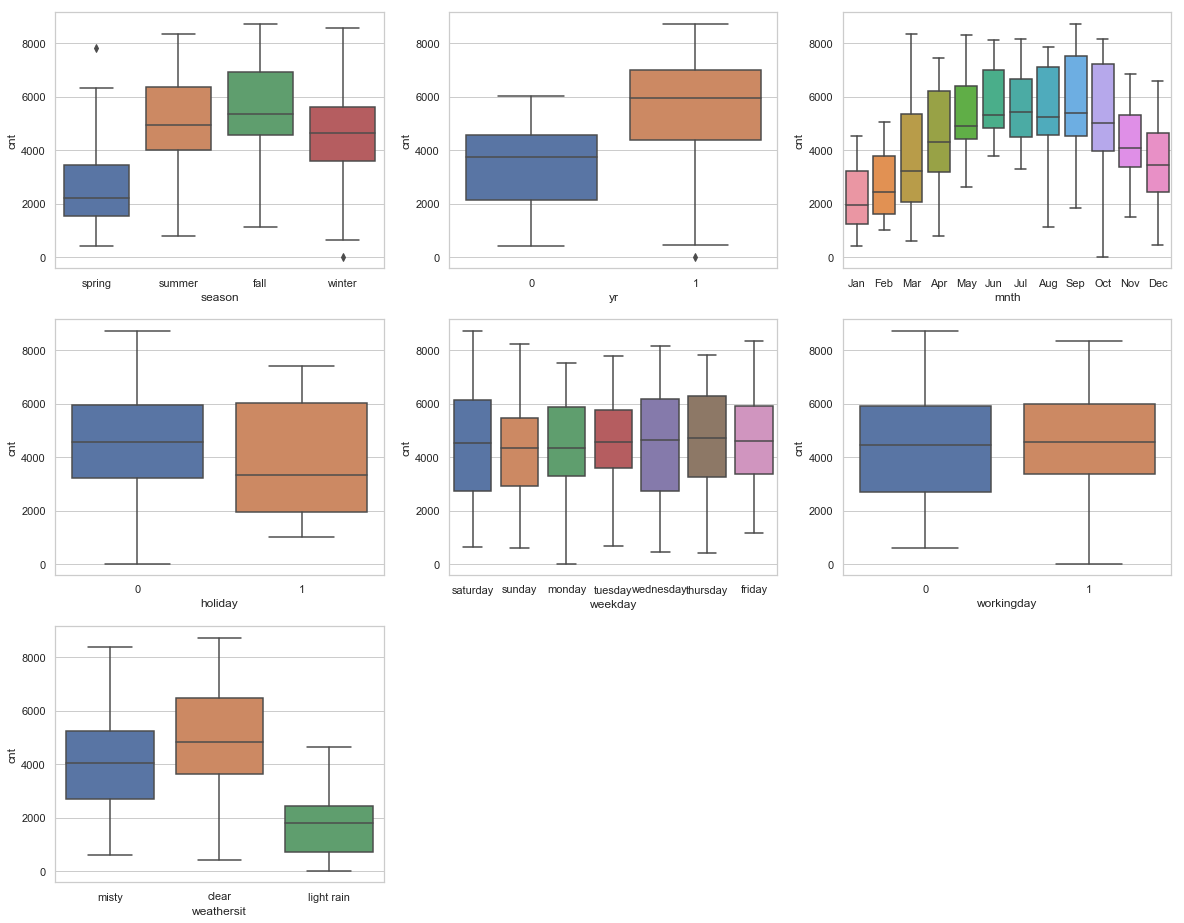

In [10]:
plt.figure(figsize=(20,16))

for cols in cat_cols:
    plt.subplot(3, 3, cat_cols.index(cols)+1)
    sns.boxplot(data=bike, x=cols, y='cnt')
    
plt.show()

### Initial inferences based on the categorical variable
- The data looks clean as we do not see any outliers in any of the columns
- The target variable (cnt) shows a general trend on
    - Season: Higher value seen for all the seasons except spring.
    - Weathersit: As expected, low numbers seen during light rains and more number of users during clear weather.
    - Year: The number of users have increased year-over-year.
    
- The trend is not significant for other variables. This might be because of the differnt type of user and we might see some trends based on users

In [68]:
bike.groupby(['mnth', 'season']).count()['cnt'].unstack()

season,fall,spring,summer,winter
mnth,,,,
Apr,NaN,NaN,60.0,NaN
Aug,62.0,NaN,NaN,NaN
Dec,NaN,22.0,NaN,40.0
Feb,NaN,56.0,NaN,NaN
Jan,NaN,62.0,NaN,NaN
Jul,62.0,NaN,NaN,NaN
Jun,20.0,NaN,40.0,NaN
Mar,NaN,40.0,22.0,NaN
May,NaN,NaN,62.0,NaN


The trend in month is similar to the trend in season with months of Dec, Jan, Feb having low number of users as these are the months of Spring.

In [75]:
bike_grp = bike.groupby(['season', 'weathersit']).count()['cnt'].unstack()
100*bike_grp.div(bike_grp.sum(axis=1), axis=0)

weathersit,clear,light rain,misty
season,,,
fall,72.340426,2.127660,25.531915
spring,61.666667,2.222222,36.111111
summer,61.413043,1.630435,36.956522
winter,57.865169,5.617978,36.516854


The fall season has clear sky during 72.3% of time and so the number os users seem high

### Relation of Casual users with all categorical variables

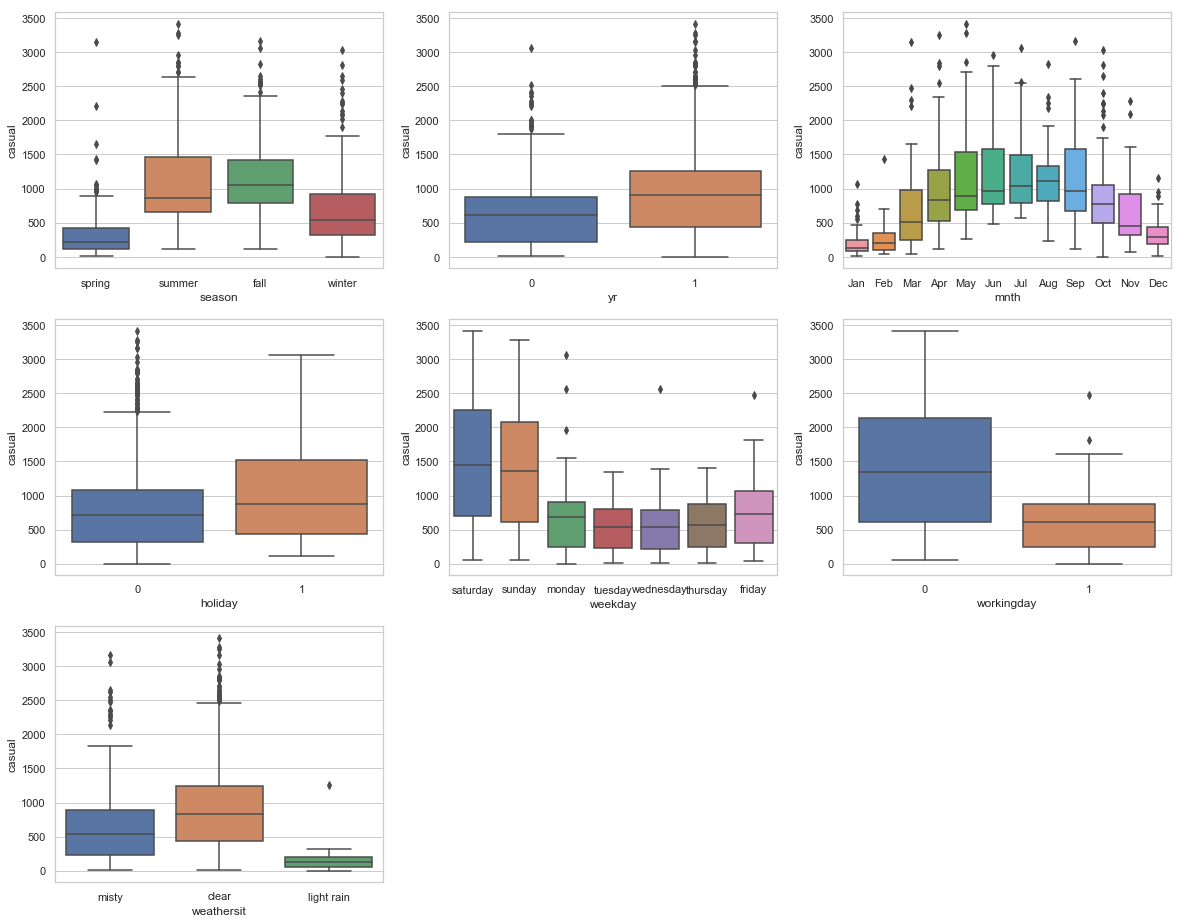

In [12]:
plt.figure(figsize=(20,16))

for cols in cat_cols:
    plt.subplot(3, 3, cat_cols.index(cols)+1)
    sns.boxplot(data=bike, x=cols, y='casual')
    
plt.show()

### Initial inferences based on the categorical variable
- The Casual users variable (casual) shows a general trend on
    - Season: Higher casual users seen during Summer and Fall
    - Month: The Spring months of Dec, Jan and Feb have lower casual users.
    - Weekday: As expected, Casual user numbers are high on Holidays, Weekends and non-working days
    - Weathersit: As expected, low numbers seen during light rains

### Relation of Registered users with all categorical variables

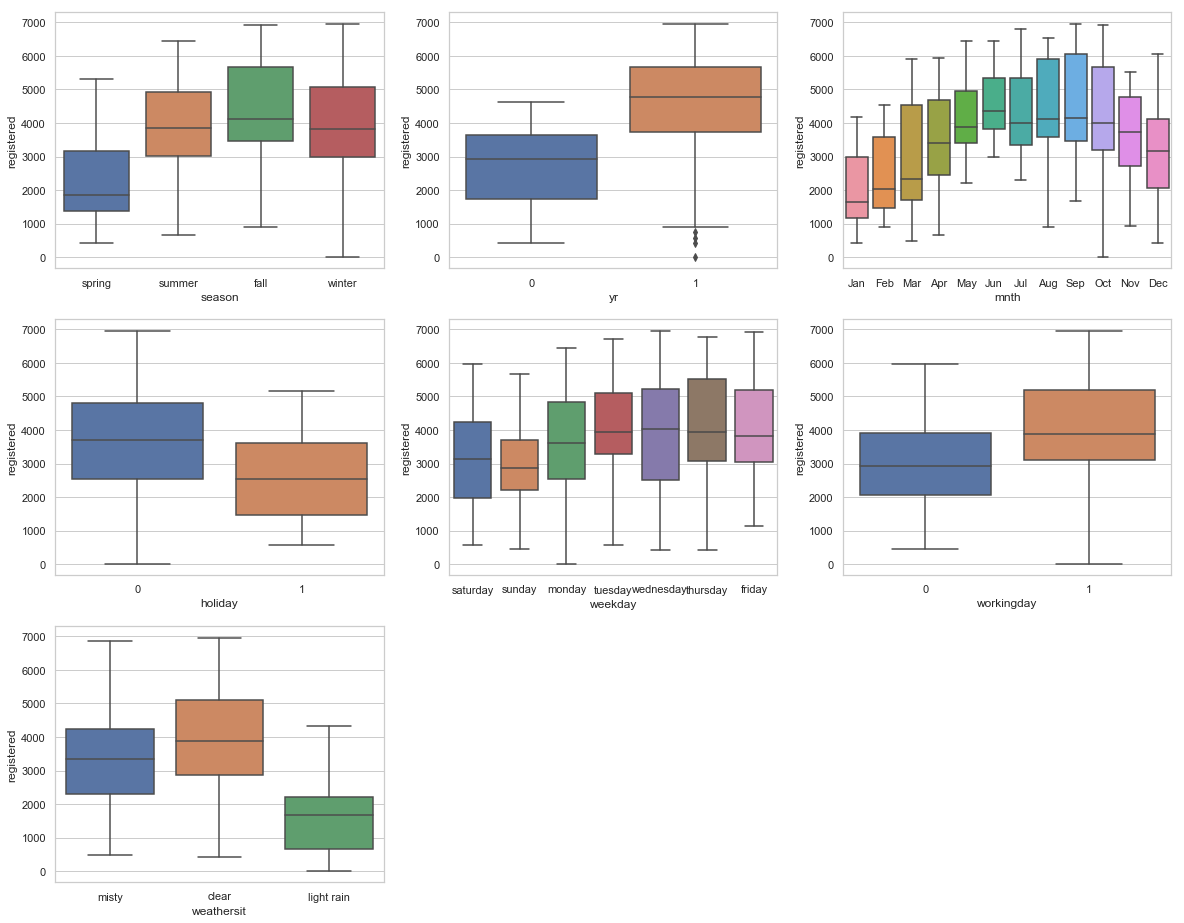

In [13]:
plt.figure(figsize=(20,16))

for cols in cat_cols:
    plt.subplot(3, 3, cat_cols.index(cols)+1)
    sns.boxplot(data=bike, x=cols, y='registered')
    
plt.show()

### Initial inferences based on the categorical variable
- The trend for registered user is similar to the target variable, however, it shows a clear trend with holiday & working day. Also the number of users have increased higher for registered than casual year-over-year.

## Since Casual users and registered users can be predicted using the other variables, it will not add any value to the model. 

## Also, sum of casual and registered is equal to the target variable, and so we can drop these variables out

In [14]:
bike = bike.drop(columns=['casual', 'registered'])

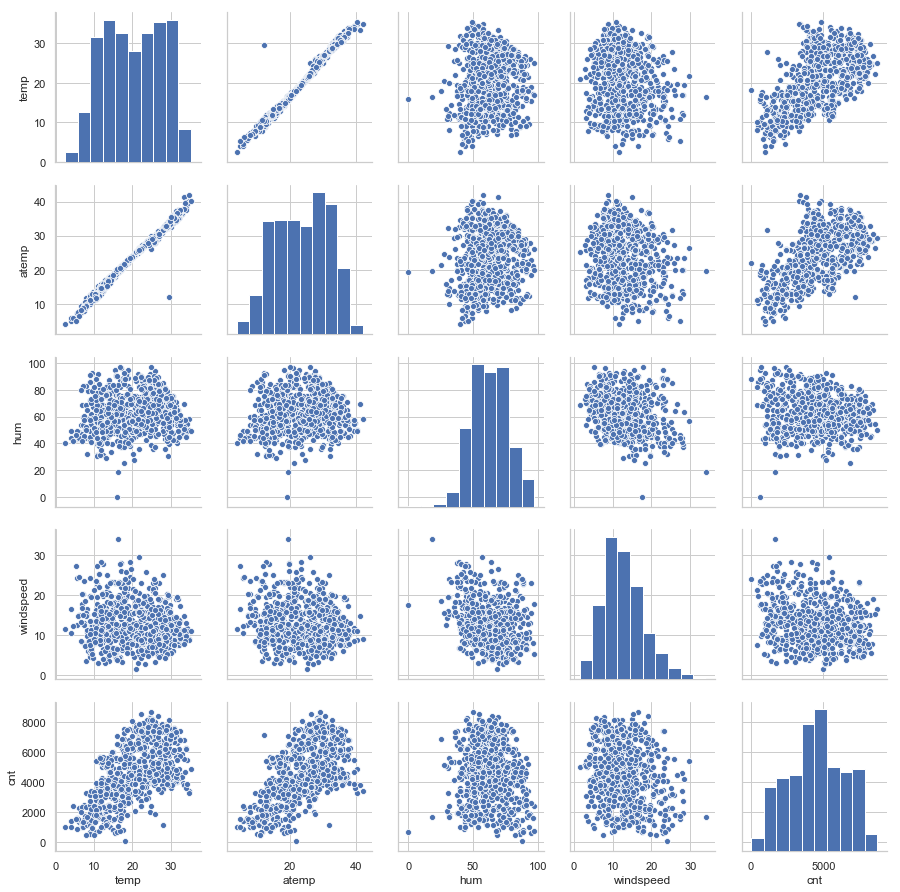

In [15]:
cont_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']
sns.pairplot(bike[cont_cols])
plt.show()

#### From the pairplot, it looks like temp can be a good variable to predict the target variable.

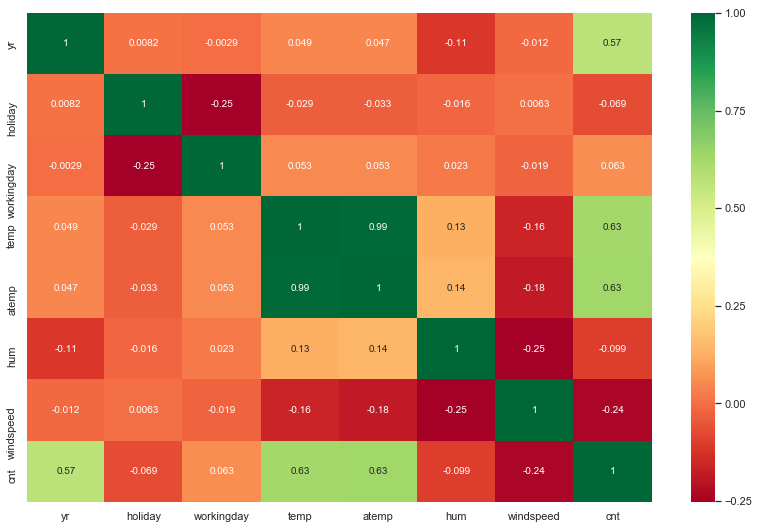

In [16]:
plt.figure(figsize=(14,9))
sns.heatmap(bike.corr(), cmap='RdYlGn', annot=True)
plt.show()

### Initial inferences based on the pairplot and heatmap:
- The target variable has a good positive correlation with:
    - temp
    - year
    
- The target variable has a good negative correlation with:
    - windspeed
    

# Step 2: Preparing the data for modelling

### Ecoding

In [17]:
# Creating dummy variables
season = pd.get_dummies(bike['season'], drop_first=True)
weathersit = pd.get_dummies(bike['weathersit'], drop_first=True)
weekday = pd.get_dummies(bike['weekday'], drop_first=True)
mnth = pd.get_dummies(bike['mnth'], drop_first=True)

In [18]:
bike_cleaned = pd.concat([bike, season, weathersit, weekday, mnth], axis=1)
bike_cleaned = bike_cleaned.drop(columns=['season', 'weathersit', 'weekday', 'mnth'])
bike_cleaned.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,spring,summer,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
instant,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,1,0,0,0,0,0,0,0
5,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,1,0,0,0,0,0,0,0


### Moving target variable towards the end of the dataframe to improve readability

In [19]:
col_list = list(bike_cleaned.columns)
col_list.pop(col_list.index('cnt'))
col_list += ['cnt']
bike_cleaned = bike_cleaned.reindex(columns=col_list)
bike_cleaned.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,winter,...,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,cnt
instant,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,14.110847,18.18125,80.5833,10.749882,1,0,0,...,0,1,0,0,0,0,0,0,0,985
2,0,0,0,14.902598,17.68695,69.6087,16.652113,1,0,0,...,0,1,0,0,0,0,0,0,0,801
3,0,0,1,8.050924,9.47025,43.7273,16.636703,1,0,0,...,0,1,0,0,0,0,0,0,0,1349
4,0,0,1,8.200000,10.60610,59.0435,10.739832,1,0,0,...,0,1,0,0,0,0,0,0,0,1562
5,0,0,1,9.305237,11.46350,43.6957,12.522300,1,0,0,...,0,1,0,0,0,0,0,0,0,1600


### Splitting into train and test

In [20]:
df_train, df_test = train_test_split(bike_cleaned, train_size=0.7, random_state=100)
print(df_train.shape)
print(df_test.shape)

(510, 30)
(220, 30)


### Scaling the variables so that they are on the same scale as the other binary columns

In [21]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
yr,510.0,0.507843,0.500429,0.000000,0.000000,1.000000,1.000000,1.000000
holiday,510.0,0.025490,0.157763,0.000000,0.000000,0.000000,0.000000,1.000000
workingday,510.0,0.676471,0.468282,0.000000,0.000000,1.000000,1.000000,1.000000
temp,510.0,20.108257,7.431626,2.424346,13.606865,20.277923,26.615847,35.328347
atemp,510.0,23.500287,8.090963,3.953480,16.603063,24.131150,30.177700,42.044800
hum,510.0,63.123710,14.153170,0.000000,52.270825,63.437500,73.250025,97.041700
windspeed,510.0,12.834912,5.292031,2.834381,9.041918,12.083182,15.750879,34.000021
spring,510.0,0.243137,0.429398,0.000000,0.000000,0.000000,0.000000,1.000000
summer,510.0,0.247059,0.431725,0.000000,0.000000,0.000000,0.000000,1.000000
winter,510.0,0.247059,0.431725,0.000000,0.000000,0.000000,0.000000,1.000000


In [22]:
var_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

In [23]:
scaler = MinMaxScaler()
df_train[var_cols] = scaler.fit_transform(df_train[var_cols])

In [24]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
yr,510.0,0.507843,0.500429,0.0,0.000000,1.000000,1.000000,1.0
holiday,510.0,0.025490,0.157763,0.0,0.000000,0.000000,0.000000,1.0
workingday,510.0,0.676471,0.468282,0.0,0.000000,1.000000,1.000000,1.0
temp,510.0,0.537440,0.225858,0.0,0.339853,0.542596,0.735215,1.0
atemp,510.0,0.513156,0.212410,0.0,0.332086,0.529718,0.688457,1.0
hum,510.0,0.650480,0.145846,0.0,0.538643,0.653714,0.754830,1.0
windspeed,510.0,0.320883,0.169803,0.0,0.199179,0.296763,0.414447,1.0
spring,510.0,0.243137,0.429398,0.0,0.000000,0.000000,0.000000,1.0
summer,510.0,0.247059,0.431725,0.0,0.000000,0.000000,0.000000,1.0
winter,510.0,0.247059,0.431725,0.0,0.000000,0.000000,0.000000,1.0


### Now that we have encoded the data, lets look at the heatmap again

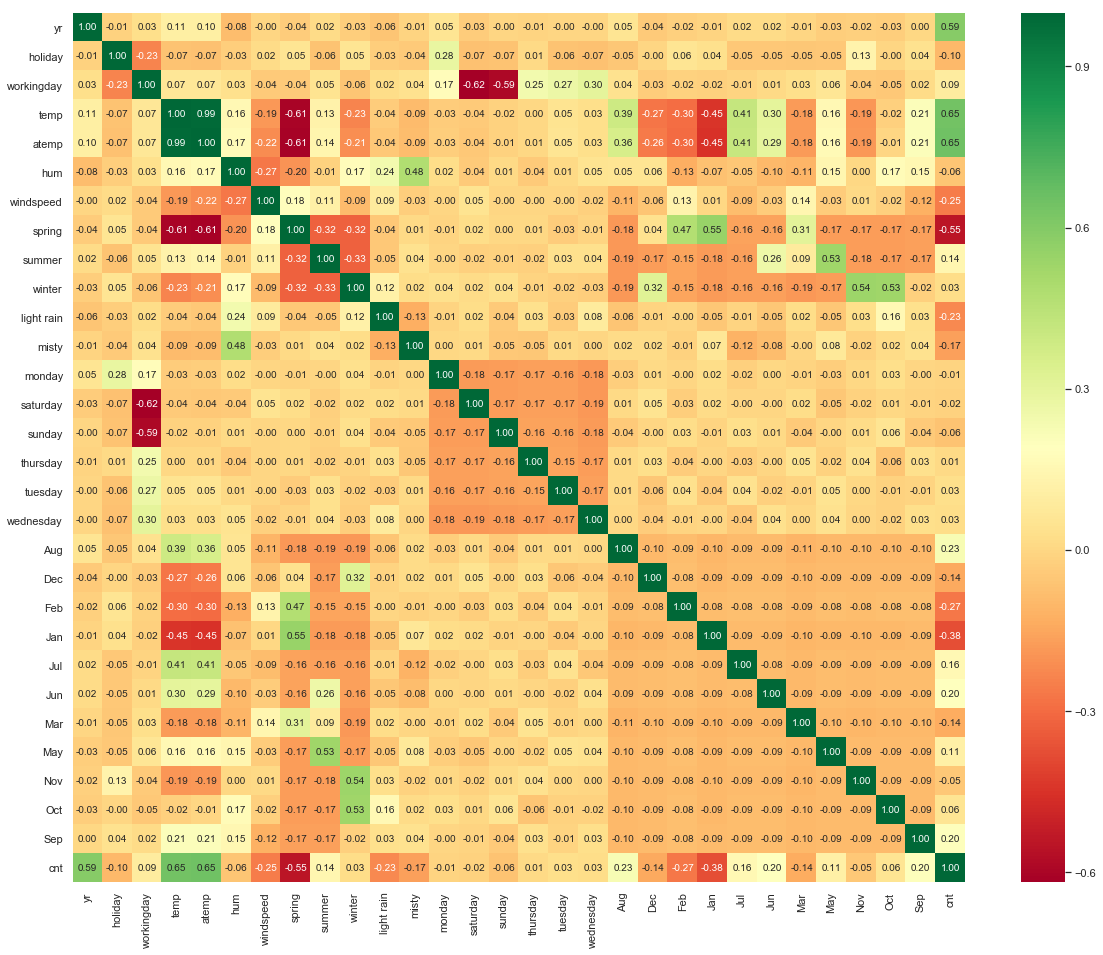

In [25]:
plt.figure(figsize=(20,16))
sns.heatmap(df_train.corr(), cmap='RdYlGn', annot=True, fmt='.2f')
plt.show()

In [26]:
df_train.corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
atemp         0.647944
temp          0.645048
yr            0.591433
Aug           0.227578
Sep           0.201639
Jun           0.195411
Jul           0.158087
summer        0.140259
May           0.113276
workingday    0.092019
Oct           0.055558
tuesday       0.030528
winter        0.025945
wednesday     0.025468
thursday      0.009928
monday       -0.009333
saturday     -0.015998
Nov          -0.048002
hum          -0.058793
sunday       -0.063214
holiday      -0.095948
Mar          -0.137465
Dec          -0.143546
misty        -0.169715
light rain   -0.226678
windspeed    -0.253038
Feb          -0.270351
Jan          -0.378296
spring       -0.548987
Name: cnt, dtype: float64

### Initial inferences:
- temp and atemp are highly correlated and so one of them can be dropped
- working day can be predicted by saturday and sunday so it might have a high VIF.

In [27]:
y_train = df_train.pop('cnt')
X_train = df_train

X_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,winter,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
instant,,,,,,,,,,,,,,,,,,,,,
577,1,0,1,0.815169,0.766351,0.725633,0.264686,0,0,0,...,0,0,0,1,0,0,0,0,0,0
427,1,0,0,0.442393,0.438975,0.640189,0.255342,1,0,0,...,0,0,0,0,0,1,0,0,0,0
729,1,0,0,0.245101,0.200348,0.498067,0.663106,1,0,0,...,1,0,0,0,0,0,0,0,0,0
483,1,0,0,0.395666,0.391735,0.504508,0.188475,0,1,0,...,0,0,0,0,0,0,0,0,0,0
112,0,0,1,0.345824,0.318819,0.751824,0.380981,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
y_train.head()

instant
577    0.827658
427    0.465255
729    0.204096
483    0.482973
112    0.191095
Name: cnt, dtype: float64

# Step 3: Automated feature selection
- Since we have 31 variables, we would be using an automated approach to determine the best features.

### Using RFE

In [29]:
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [30]:
# Running RFE with the output number of the variable equal to 10
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 15)             # running RFE
rfe = rfe.fit(X_train, y_train)

### Since we do not know how many feature variables would be a good predictor, we will start by selecting 15 and then higher or lower based on the results

In [31]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 8),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('spring', True, 1),
 ('summer', False, 9),
 ('winter', True, 1),
 ('light rain', True, 1),
 ('misty', True, 1),
 ('monday', False, 5),
 ('saturday', True, 1),
 ('sunday', True, 1),
 ('thursday', False, 13),
 ('tuesday', False, 6),
 ('wednesday', False, 11),
 ('Aug', True, 1),
 ('Dec', False, 3),
 ('Feb', False, 12),
 ('Jan', False, 14),
 ('Jul', True, 1),
 ('Jun', True, 1),
 ('Mar', False, 4),
 ('May', False, 10),
 ('Nov', False, 2),
 ('Oct', False, 7),
 ('Sep', False, 15)]

In [32]:
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'spring',
       'winter', 'light rain', 'misty', 'saturday', 'sunday', 'Aug', 'Jul',
       'Jun'],
      dtype='object')

## Building model using statsmodel, for the detailed statistics

In [33]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

In [34]:
# Adding a constant variable 
X_train_rfe = sm.add_constant(X_train_rfe)

# Running the linear model
lr = sm.OLS(y_train,X_train_rfe)
lm = lr.fit()

#Let's see the summary of our linear model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     191.2
Date:                Sun, 10 Jul 2022   Prob (F-statistic):          2.77e-189
Time:                        12:41:07   Log-Likelihood:                 512.56
No. Observations:                 510   AIC:                            -995.1
Df Residuals:                     495   BIC:                            -931.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2369      0.025      9.392      0.000       0.187       0.286
yr             0.2293      0.008     28.293      0.000       0.213       0.245
holiday       -0.0101      0.021     -0.475      0.635      -0.052       0.032
workingday     0.0925      0.009     10.016      0.000       0.074       0.111
temp           0.5662      0.035     16.324      0.000       0.498       0.634
hum           -0.1673      0.038     -4.381      0.000      -0.242      -0.092
windspeed     -0.1875      0.026     -7.348      0.000      -0.238      -0.137
spring        -0.1077      0.015     -7.272      0.000      -0.137      -0.079
winter         0.0472      0.012      3.800      0.000       0.023       0.072
light rain    -0.2447      0.026     -9.305      0.000      -0.296      -0.193
misty         -0.0547      0.011     -5.207      0.000      -0.075      -0.034
saturday       0.1048      0.011      9.213      0.000       0.082       0.127
sunday         0.0497      0.012      4.156      0.000       0.026       0.073
Aug           -0.0666      0.017     -3.950      0.000      -0.100      -0.033
Jul           -0.1287      0.019     -6.707      0.000      -0.166      -0.091
Jun           -0.0519      0.018     -2.902      0.004      -0.087      -0.017
==============================================================================
Omnibus:                       65.273   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.369
Skew:                          -0.671   Prob(JB):                     1.11e-34
Kurtosis:                       5.358   Cond. No.                     2.38e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.61e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [35]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,holiday,inf
3,workingday,inf
11,saturday,inf
12,sunday,inf
4,temp,3.860000
7,spring,2.550000
5,hum,1.950000
8,winter,1.810000
14,Jul,1.640000
10,misty,1.570000


### Dropping holiday as it has high p-value and high VIF

In [36]:
X_train_rfe_new = X_train_rfe.drop(columns=['holiday'])

In [37]:
# Adding a constant variable 
X_train_rfe_new = sm.add_constant(X_train_rfe_new)

# Running the linear model
lr = sm.OLS(y_train, X_train_rfe_new)
lm = lr.fit()

#Let's see the summary of our linear model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     191.2
Date:                Sun, 10 Jul 2022   Prob (F-statistic):          2.77e-189
Time:                        12:41:07   Log-Likelihood:                 512.56
No. Observations:                 510   AIC:                            -995.1
Df Residuals:                     495   BIC:                            -931.6
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2268      0.040      5.694      0.000       0.149       0.305
yr             0.2293      0.008     28.293      0.000       0.213       0.245
workingday     0.1027      0.026      4.007      0.000       0.052       0.153
temp           0.5662      0.035     16.324      0.000       0.498       0.634
hum           -0.1673      0.038     -4.381      0.000      -0.242      -0.092
windspeed     -0.1875      0.026     -7.348      0.000      -0.238      -0.137
spring        -0.1077      0.015     -7.272      0.000      -0.137      -0.079
winter         0.0472      0.012      3.800      0.000       0.023       0.072
light rain    -0.2447      0.026     -9.305      0.000      -0.296      -0.193
misty         -0.0547      0.011     -5.207      0.000      -0.075      -0.034
saturday       0.1149      0.027      4.240      0.000       0.062       0.168
sunday         0.0598      0.027      2.198      0.028       0.006       0.113
Aug           -0.0666      0.017     -3.950      0.000      -0.100      -0.033
Jul           -0.1287      0.019     -6.707      0.000      -0.166      -0.091
Jun           -0.0519      0.018     -2.902      0.004      -0.087      -0.017
==============================================================================
Omnibus:                       65.273   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.369
Skew:                          -0.671   Prob(JB):                     1.11e-34
Kurtosis:                       5.358   Cond. No.                         24.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe_new.values, i) for i in range(X_train_rfe_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,100.11
2,workingday,9.07
10,saturday,6.07
11,sunday,5.73
3,temp,3.86
6,spring,2.55
4,hum,1.95
7,winter,1.81
13,Jul,1.64
9,misty,1.57


### Dropping Sunday as it has high p-value and VIF

In [39]:
X_train_rfe_new = X_train_rfe_new.drop(columns=['sunday'])

In [40]:
# Adding a constant variable 
X_train_rfe_new = sm.add_constant(X_train_rfe_new)

# Running the linear model
lr = sm.OLS(y_train, X_train_rfe_new)
lm = lr.fit()

#Let's see the summary of our linear model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     204.0
Date:                Sun, 10 Jul 2022   Prob (F-statistic):          2.08e-189
Time:                        12:41:08   Log-Likelihood:                 510.08
No. Observations:                 510   AIC:                            -992.2
Df Residuals:                     496   BIC:                            -932.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2775      0.033      8.518      0.000       0.214       0.342
yr             0.2296      0.008     28.225      0.000       0.214       0.246
workingday     0.0518      0.011      4.710      0.000       0.030       0.073
temp           0.5631      0.035     16.186      0.000       0.495       0.631
hum           -0.1649      0.038     -4.302      0.000      -0.240      -0.090
windspeed     -0.1874      0.026     -7.315      0.000      -0.238      -0.137
spring        -0.1091      0.015     -7.345      0.000      -0.138      -0.080
winter         0.0462      0.012      3.710      0.000       0.022       0.071
light rain    -0.2441      0.026     -9.248      0.000      -0.296      -0.192
misty         -0.0545      0.011     -5.171      0.000      -0.075      -0.034
saturday       0.0641      0.014      4.523      0.000       0.036       0.092
Aug           -0.0649      0.017     -3.841      0.000      -0.098      -0.032
Jul           -0.1260      0.019     -6.555      0.000      -0.164      -0.088
Jun           -0.0497      0.018     -2.770      0.006      -0.085      -0.014
==============================================================================
Omnibus:                       71.851   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              183.342
Skew:                          -0.714   Prob(JB):                     1.54e-40
Kurtosis:                       5.567   Cond. No.                         21.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [41]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe_new.values, i) for i in range(X_train_rfe_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,66.48
3,temp,3.86
6,spring,2.54
4,hum,1.95
7,winter,1.81
2,workingday,1.65
10,saturday,1.64
12,Jul,1.63
9,misty,1.57
11,Aug,1.55


### Dropping Spring as it has VIF>5

In [42]:
X_train_rfe_new = X_train_rfe_new.drop(columns=['Jun'])

In [43]:
# Adding a constant variable 
X_train_rfe_new = sm.add_constant(X_train_rfe_new)

# Running the linear model
lr = sm.OLS(y_train, X_train_rfe_new)
lm = lr.fit()

#Let's see the summary of our linear model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     217.4
Date:                Sun, 10 Jul 2022   Prob (F-statistic):          6.12e-189
Time:                        12:41:08   Log-Likelihood:                 506.17
No. Observations:                 510   AIC:                            -986.3
Df Residuals:                     497   BIC:                            -931.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2743      0.033      8.368      0.000       0.210       0.339
yr             0.2306      0.008     28.195      0.000       0.215       0.247
workingday     0.0522      0.011      4.720      0.000       0.030       0.074
temp           0.5269      0.032     16.231      0.000       0.463       0.591
hum           -0.1457      0.038     -3.838      0.000      -0.220      -0.071
windspeed     -0.1822      0.026     -7.084      0.000      -0.233      -0.132
spring        -0.1090      0.015     -7.286      0.000      -0.138      -0.080
winter         0.0504      0.012      4.051      0.000       0.026       0.075
light rain    -0.2459      0.027     -9.257      0.000      -0.298      -0.194
misty         -0.0555      0.011     -5.232      0.000      -0.076      -0.035
saturday       0.0636      0.014      4.459      0.000       0.036       0.092
Aug           -0.0474      0.016     -3.004      0.003      -0.078      -0.016
Jul           -0.1056      0.018     -5.908      0.000      -0.141      -0.070
==============================================================================
Omnibus:                       73.260   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.754
Skew:                          -0.722   Prob(JB):                     6.24e-42
Kurtosis:                       5.616   Cond. No.                         20.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe_new.values, i) for i in range(X_train_rfe_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,66.39
3,temp,3.31
6,spring,2.54
4,hum,1.89
7,winter,1.78
2,workingday,1.65
10,saturday,1.64
9,misty,1.57
12,Jul,1.39
11,Aug,1.34


### Dropping Aug as it has relatively high p-value

In [45]:
X_train_rfe_new = X_train_rfe_new.drop(columns=['Aug'])

In [46]:
# Adding a constant variable 
X_train_rfe_new = sm.add_constant(X_train_rfe_new)

# Running the linear model
lr = sm.OLS(y_train, X_train_rfe_new)
lm = lr.fit()

#Let's see the summary of our linear model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     232.6
Date:                Sun, 10 Jul 2022   Prob (F-statistic):          3.37e-188
Time:                        12:41:08   Log-Likelihood:                 501.58
No. Observations:                 510   AIC:                            -979.2
Df Residuals:                     498   BIC:                            -928.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2811      0.033      8.529      0.000       0.216       0.346
yr             0.2307      0.008     27.977      0.000       0.214       0.247
workingday     0.0515      0.011      4.622      0.000       0.030       0.073
temp           0.4937      0.031     16.046      0.000       0.433       0.554
hum           -0.1393      0.038     -3.646      0.000      -0.214      -0.064
windspeed     -0.1760      0.026     -6.811      0.000      -0.227      -0.125
spring        -0.1108      0.015     -7.356      0.000      -0.140      -0.081
winter         0.0534      0.013      4.272      0.000       0.029       0.078
light rain    -0.2461      0.027     -9.190      0.000      -0.299      -0.193
misty         -0.0571      0.011     -5.350      0.000      -0.078      -0.036
saturday       0.0618      0.014      4.306      0.000       0.034       0.090
Jul           -0.0885      0.017     -5.182      0.000      -0.122      -0.055
==============================================================================
Omnibus:                       66.469   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              178.198
Skew:                          -0.646   Prob(JB):                     2.02e-39
Kurtosis:                       5.592   Cond. No.                         20.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [47]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe_new.values, i) for i in range(X_train_rfe_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,66.07
3,temp,2.93
6,spring,2.54
4,hum,1.88
7,winter,1.77
2,workingday,1.65
10,saturday,1.64
9,misty,1.57
11,Jul,1.25
8,light rain,1.24


### Checking the heatmap of these variables to see if we have any multi-colinearity

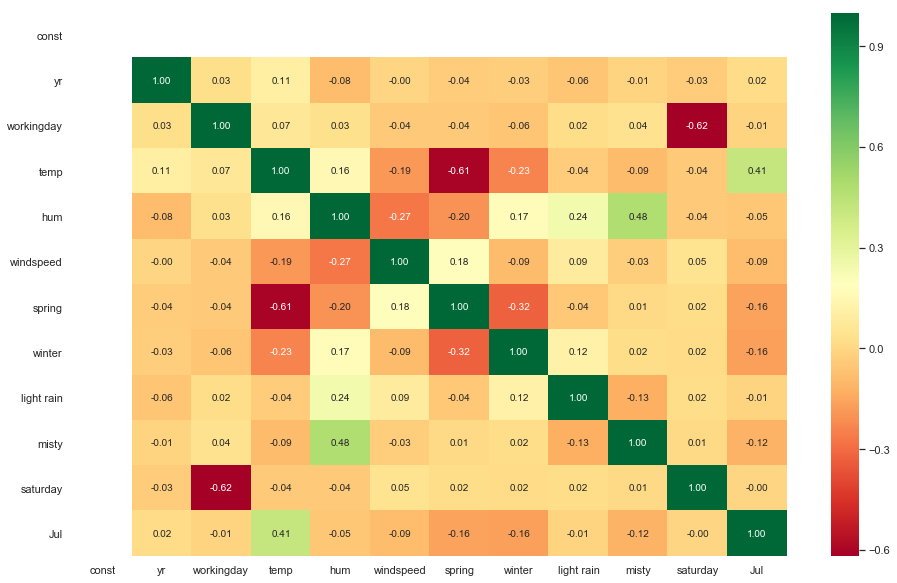

In [48]:
plt.figure(figsize=(16,10))
sns.heatmap(X_train_rfe_new.corr(), cmap='RdYlGn', annot=True, fmt='.2f')
plt.show()

### Working day and Saturday seems to be highly corelated and so one of them can be dropped
### Also dropping spring since it is highly correlated with temp and since temp is a better predictor

In [49]:
X_train_rfe_new = X_train_rfe_new.drop(columns=['saturday', 'spring'])

In [50]:
# Adding a constant variable 
X_train_rfe_new = sm.add_constant(X_train_rfe_new)

# Running the linear model
lr = sm.OLS(y_train, X_train_rfe_new)
lm = lr.fit()

#Let's see the summary of our linear model
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     241.7
Date:                Sun, 10 Jul 2022   Prob (F-statistic):          8.81e-176
Time:                        12:41:08   Log-Likelihood:                 466.55
No. Observations:                 510   AIC:                            -913.1
Df Residuals:                     500   BIC:                            -870.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2011      0.030      6.781      0.000       0.143       0.259
yr             0.2266      0.009     25.754      0.000       0.209       0.244
workingday     0.0231      0.009      2.476      0.014       0.005       0.041
temp           0.6578      0.023     28.544      0.000       0.613       0.703
hum           -0.1695      0.041     -4.172      0.000      -0.249      -0.090
windspeed     -0.1795      0.028     -6.499      0.000      -0.234      -0.125
winter         0.1075      0.011      9.990      0.000       0.086       0.129
light rain    -0.2274      0.029     -7.978      0.000      -0.283      -0.171
misty         -0.0465      0.011     -4.107      0.000      -0.069      -0.024
Jul           -0.1016      0.018     -5.590      0.000      -0.137      -0.066
==============================================================================
Omnibus:                       32.629   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.227
Skew:                          -0.342   Prob(JB):                     1.26e-16
Kurtosis:                       4.726   Cond. No.                         20.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe_new.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe_new.values, i) for i in range(X_train_rfe_new.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
0,const,46.79
4,hum,1.87
8,misty,1.54
3,temp,1.44
9,Jul,1.24
7,light rain,1.23
5,windspeed,1.17
6,winter,1.15
1,yr,1.03
2,workingday,1.01


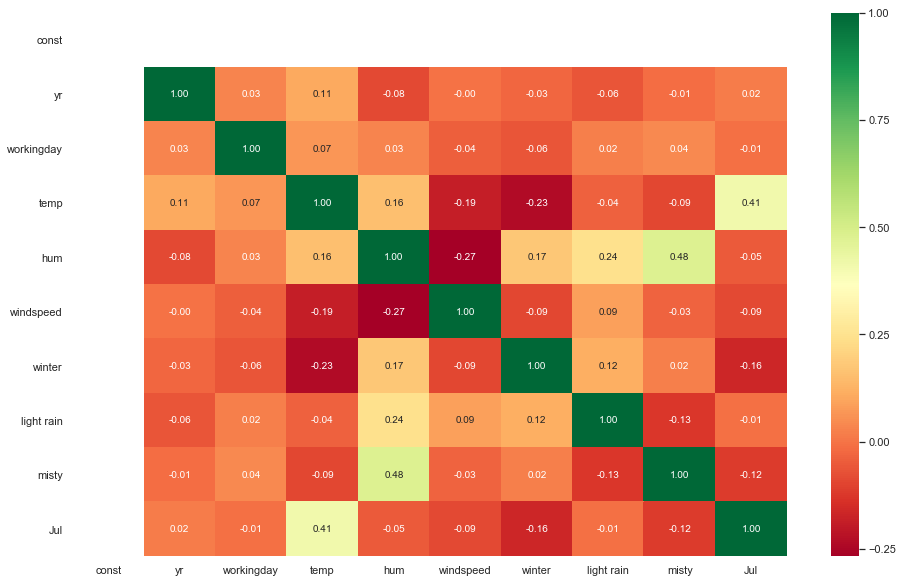

In [52]:
plt.figure(figsize=(16,10))
sns.heatmap(X_train_rfe_new.corr(), cmap='RdYlGn', annot=True, fmt='.2f')
plt.show()

## Since all the features have a low p-value, low VIF and corelations among each other is low, we can stop with the feature selection process

# `Residual Analaysis`

### Predict the train dataset

In [53]:
y_train_pred = lm.predict(X_train_rfe_new)

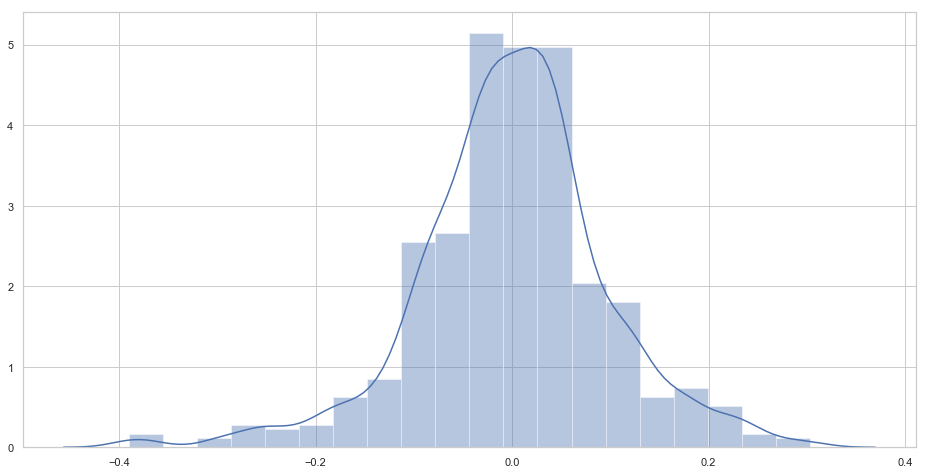

In [54]:
# Plot the histogram of the error terms
plt.figure(figsize=(16,8))
res = y_train - y_train_pred
sns.distplot(res, bins = 20)
plt.show()

### The distribution looks like normally distributed with median aligned towards 0 and not sharp peaks

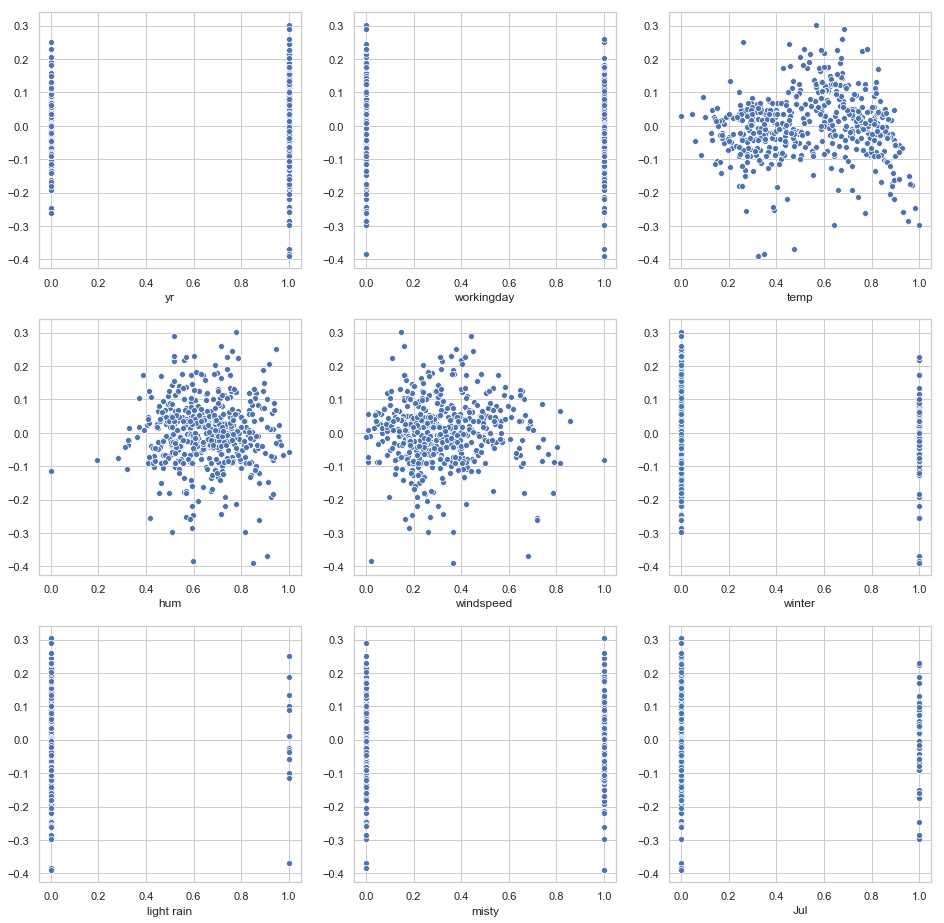

In [55]:
# Plot the histogram of the error terms
plt.figure(figsize=(16,16))
res = y_train - y_train_pred

cnt = 1
for col in list(X_train_rfe_new.columns)[1:]:
    plt.subplot(3,3,cnt)
    sns.scatterplot(X_train[col], res)
    cnt += 1

plt.show()
    

### The residuals do not have any particular patter and they are spread out evenly. Thus we can say that it is homoscedastic.

# `Making Predictions`
Applying the scaling on the test sets

In [56]:
var_cols = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

df_test[var_cols] = scaler.transform(df_test[var_cols])
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,spring,summer,winter,...,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,cnt
instant,,,,,,,,,,,,,,,,,,,,,
185,0,1,0,0.831783,0.769660,0.657364,0.084219,0,0,0,...,0,0,1,0,0,0,0,0,0,0.692706
536,1,0,1,0.901354,0.842587,0.610133,0.153728,0,1,0,...,0,0,0,1,0,0,0,0,0,0.712034
300,0,0,1,0.511964,0.496145,0.837699,0.334206,0,0,1,...,0,0,0,0,0,0,0,1,0,0.303382
222,0,0,1,0.881625,0.795343,0.437098,0.339570,0,0,0,...,0,0,0,0,0,0,0,0,0,0.547400
153,0,0,1,0.817246,0.741471,0.314298,0.537414,0,1,0,...,0,0,0,1,0,0,0,0,0,0.569029


In [57]:
df_test.describe().T

,count,mean,std,min,25%,50%,75%,max
yr,220.0,0.481818,0.500809,0.000000,0.000000,0.000000,1.000000,1.000000
holiday,220.0,0.036364,0.187620,0.000000,0.000000,0.000000,0.000000,1.000000
workingday,220.0,0.700000,0.459303,0.000000,0.000000,1.000000,1.000000,1.000000
temp,220.0,0.558718,0.233187,0.046591,0.355429,0.558172,0.755981,0.984424
atemp,220.0,0.532847,0.217401,0.025950,0.344870,0.544652,0.713308,0.980934
hum,220.0,0.638221,0.148694,0.261915,0.529197,0.625590,0.743798,1.002146
windspeed,220.0,0.313293,0.159584,-0.042808,0.198843,0.300126,0.402718,0.807474
spring,220.0,0.254545,0.436599,0.000000,0.000000,0.000000,1.000000,1.000000
summer,220.0,0.263636,0.441609,0.000000,0.000000,0.000000,1.000000,1.000000
winter,220.0,0.236364,0.425817,0.000000,0.000000,0.000000,0.000000,1.000000


In [58]:
y_test = df_test.pop('cnt')
X_test = df_test

In [59]:
# Now let's use our model to make predictions.

# Creating X_test_new dataframe by dropping variables from X_test

X_test_sm = sm.add_constant(X_test)
X_test_sm = X_test_sm[X_train_rfe_new.columns]
X_test_sm.head()


,const,yr,workingday,temp,hum,windspeed,winter,light rain,misty,Jul
instant,,,,,,,,,,
185,1.0,0,0,0.831783,0.657364,0.084219,0,0,1,1
536,1.0,1,1,0.901354,0.610133,0.153728,0,0,0,0
300,1.0,0,1,0.511964,0.837699,0.334206,1,0,1,0
222,1.0,0,1,0.881625,0.437098,0.339570,0,0,0,0
153,1.0,0,1,0.817246,0.314298,0.537414,0,0,0,0


In [60]:
#Predict 
y_test_pred = lm.predict(X_test_sm)

In [61]:
#Evaluate the predictions
r2_score(y_true=y_test, y_pred=y_test_pred)

0.7834157137957104

##  The R-squared on the test data is 78.3 which is very close to 81.3 in the train set, and so we can conclude that the model is correct.

Text(0,0.5,'y_pred')

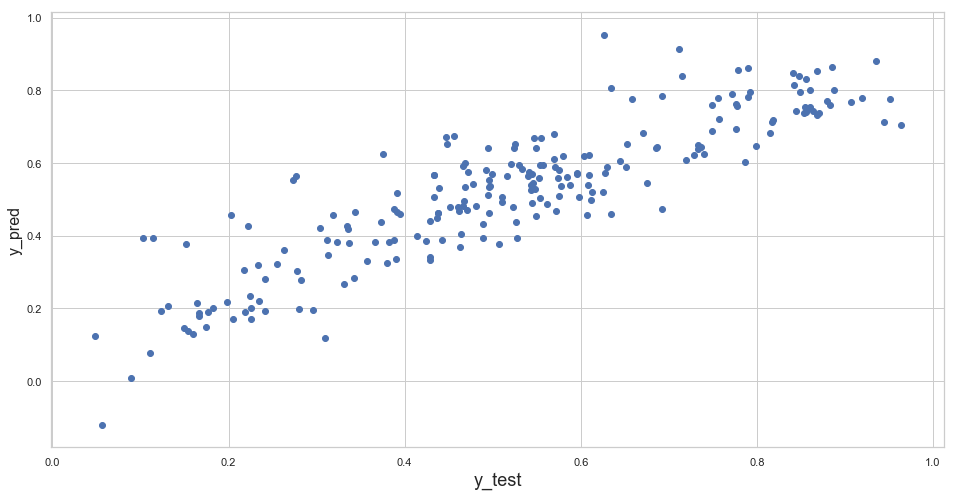

In [62]:
# Plotting y_test and y_pred to understand the spread.
plt.figure(figsize=(16,8))
plt.scatter(y_test, y_test_pred)
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                         # Y-label

# Model conclusion

We are considering the below features as significant as they have a low p-value and low VIF
- temp
- yr
- winter
- workingday
- misty
- Jul
- hum
- windspeed
- light rain

where temp has the highest positive co-efficient of 0.6578 while light rain has the higest negative co-efficient of -0.2274.
The slope of the hyper plane can be represented as follows:

y = 0.6578 X temp + 0.2266 X yr + 0.1075 X winter + 0.0231 X workingday - 0.0465 X misty - 0.1016 X Jul - 0.1695 X hum - 0.1795 X windspeed - 0.2274 X light rain + 0.2011